In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from sympy.plotting import plot
import operator
from IPython.display import Image
from IPython.core.display import HTML 

In [2]:
def nullcline_intersection(sys, r):
    x, y = sp.symbols('x, y')
    eq1 = sys(x, y, r)[0]
    eq2 = sys(x, y, r)[1]
    sols = sp.solve([eq1, eq2], [x, y])
    return np.array(sols,dtype=float)

def plot_flow(sys, r, x_window, y_window, num_arrows):
    
    linx = np.linspace(x_window[0], x_window[1], num_arrows)
    liny = np.linspace(y_window[0], y_window[1], num_arrows)
    X, Y = np.meshgrid(linx, liny)
    
    Xa = sys(X, Y, r)[0]
    Ya = sys(X, Y, r)[1]
    
    n = np.sqrt(Xa*Xa + Ya*Ya)
    plt.title('Slope Field and Nullcline Intersections');
    plt.quiver(X, Y, Xa/n, Ya/n, color='g');
    

def str_to_func(s):
    return eval(f'lambda x, y : {s}')

In [3]:
def jacsysFC(k,c,r):
    # G1 = dc/dt
    # G2 = dk/dt
    # J = [dG1/dc, dG1/dk
    #      dG2/dc, dG2/dk]
    alpha, delta, xt, n, rho, b, gamma = r[0], r[1], r[2], r[3], r[4], r[5], r[6]
    J = np.array([[alpha*k**(alpha-1)-(delta+xt+n), -1],
    [c*alpha*(alpha-1)*k**(alpha-2), alpha*k**(alpha-1) - (delta+xt) - rho]])
    return J

# Jacobian of the Full Comittment Case
def dFull(k,c,r):
    alpha, delta, xt, n, rho, b, gamma = r[0], r[1], r[2], r[3], r[4], r[5], r[6]
    G1 = k**alpha - (delta+xt+n)*k - c
    G2 = c*(alpha*k**(alpha-1) - (delta+xt) - rho) # b*exp(-gamma*t) -> 0 as t -> infty
    # returning the array [dK, dC]
    return [G1, G2]

# Jacobian of the No Comittment Case
def dNo(k,c,r):
    alpha, delta, xt, n, rho, b, gamma = r[0], r[1], r[2], r[3], r[4], r[5], r[6]
    G1 = k**alpha - (delta+xt+n)*k - c
    G2 = c*(alpha*k**(alpha-1) - (delta+xt) - lam)
    # returning the array [dK, dC]
    return [G1, G2]

def dJ(k,c,r):
    return [r[0]*k+r[1]*c,r[2]*k+r[3]*c]

def jacobian(sys, eq, r):
    x = sp.Symbol('k'); y = sp.Symbol('c')
    x_eq = sys(x, y, r)[0]
    y_eq = sys(x, y, r)[1]
    jac = [ [ sp.Derivative(x_eq, x).doit(), sp.Derivative(x_eq, y).doit() ], 
           [ sp.Derivative(y_eq, x).doit(), sp.Derivative(y_eq, y).doit()]]
    fnr1 = [ str_to_func(e.__repr__()) for e in jac[0] ]
    fnr2 = [ str_to_func(e.__repr__()) for e in jac[1] ]
    return [fnr1, fnr2]

def print_jacobian(sys,r):
    x = sp.Symbol('k'); y = sp.Symbol('c')
    x_eqn = sys(x, y, r)[0]
    y_eqn = sys(x, y, r)[1]
    jac = [ [ sp.Derivative(x_eqn, x).doit(), sp.Derivative(x_eqn, y).doit() ], 
           [ sp.Derivative(y_eqn, x).doit(), sp.Derivative(y_eqn, y).doit()]]
    print(jac)

In [4]:
print_jacobian(dNo,r)

NameError: name 'r' is not defined

## RK4 and Linearized System

In [5]:
## using keiths notes on full commitment
def rk4(t,y,h,func,J):
    k1 = h*func(t,y,J)
    k2 = h*func(t+0.5*h,y+0.5*k1,J)
    k3 = h*func(t+0.5*h,y+0.5*k2,J)
    k4 = h*func(t+h,y+k3,J)
    return (k1 + 2*k2 + 2*k3 + k4)/6

# Homebrew Solver: Euler's Method
def rk4_solve(t0,tf,h,y0,func,J):
    tv, yv, = [], []
    t, y = t0, y0
    while t < tf:
        y += rk4(t,y,h,func,J)
        t += h
        yv.append(y.copy())
        tv.append(t)
    return np.array(tv), np.array(yv)

def F(t,U,J):
    # System of Equations
    return np.array([ J[0,0]*U[0] + J[0,1]*U[1],
                      J[1,0]*U[0] + J[1,1]*U[1]])

In [7]:
alpha, delta, xt, n = 0.75, 0.05, 0.02, 0.01
rho, b, gamma = 0.02, 0.5, 0.5
lam = .03653
r = (alpha, delta, xt, n, rho, b, gamma)

eq = nullcline_intersection(dFull,r)
kstar, cstar = eq[0][0], eq[0][1]
ca, cb, ka, kb = 1e-6, cstar *1.1, 1e-6, kstar * 1.1

### No Commitment Case

In [8]:
# Equations of k*_0 and c*_0 for No Commitment
kzed = (alpha/(delta + lam + xt))**(1/(1-alpha)) 
czed = kzed**alpha - (delta + n + xt)*kzed 

eq = nullcline_intersection(dNo,r)
c = np.linspace(ca-czed,cb-czed)
k = np.linspace(ka-kzed,kb-kzed)
JNo = jacsysFC(kstar,cstar,r)
JentriesNo = (JNo[0,0],JNo[0,1],JNo[1,0],JNo[1,1])


print("The Jacobian Matrix of the No Committment case:")
print(JNo)
print(" ")
print("The Eigenvalues and Eigenvectors of the No Commmittment Case:")
print(np.linalg.eig(JNo))

The Jacobian Matrix of the No Committment case:
[[ 1.00000000e-02 -1.00000000e+00]
 [-9.00000000e-04 -1.04083409e-17]]
 
The Eigenvalues and Eigenvectors of the No Commmittment Case:
(array([ 0.03541381, -0.02541381]), array([[ 0.99967723,  0.99937352],
       [-0.02540561,  0.03539163]]))


[[ 1.00000000e-02 -1.00000000e+00]
 [-9.00000000e-04 -1.04083409e-17]]


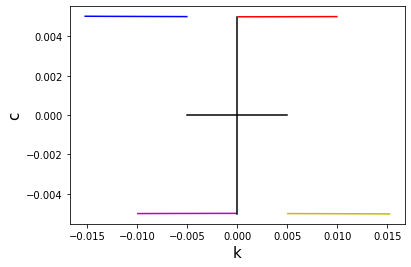

In [9]:
UpLfQ = [-0.005, .005]  # Value in upper left quadrant (Blue)
UpRtQ = [0.01, .005]   # Value in upper right quadrant (Red)
LwLfQ = [-0.01, -0.005] # Value in lower left quadrantn(Purple)
LwRtQ = [0.005, -0.005]  # Value in lower right quadrant (Yellow)

# Values in the Jacobian of the No Comittment Case
JentriesNo = np.array([[JNo[0,0],JNo[0,1]],[JNo[1,0],JNo[1,1]]])
print(JentriesNo)

tNo,vNo = rk4_solve(0,2,1e-2, UpLfQ,F,JNo)
tNo2,vNo2 = rk4_solve(0,2,1e-2, UpRtQ,F,JNo)
tNo3,vNo3 = rk4_solve(0,2,1e-2, LwLfQ,F,JNo)
tNo4,vNo4 = rk4_solve(0,2,1e-2, LwRtQ,F,JNo)

plt.plot(vNo[:,0],vNo[:,1], 'b',vNo2[:,0], vNo2[:,1],'r',vNo3[:,0], vNo3[:,1],'m',vNo4[:,0], vNo4[:,1],'y',
         [-.005,.0050],[0,0],'k',[0,0],[-.0050, .0050],'k');
plt.xlabel('k',size=15)
plt.ylabel('c',size=15);

###### The paths around the stable point, displaying the saddle paths for above the stable point.

The green circle is the starting point, and the direction the line goes shows the character of how that point reacts around the steady state.

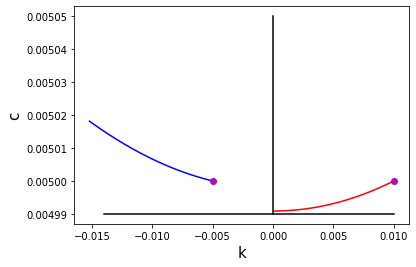

In [10]:
plt.plot(vNo[:,0],vNo[:,1], 'b', vNo2[:,0],vNo2[:,1], 'r',
         [0,0],[0.00499,.00505], 'black', [-.014, .010], [.00499,.00499], 'black',UpRtQ[0],UpRtQ[1],'mo',UpLfQ[0],UpLfQ[1],'mo');
plt.xlabel('k',size=15)
plt.ylabel('c',size=15);

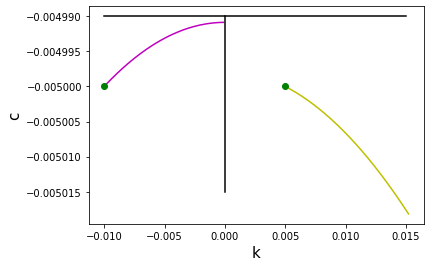

In [11]:
plt.plot(vNo3[:,0],vNo3[:,1], 'm', vNo4[:,0],vNo4[:,1], 'y',
         [0,0],[-0.00499,-0.005015], 'black', [-.010, .015], [-0.00499,-.00499], 'black', LwRtQ[0],LwRtQ[1],'go',LwLfQ[0],LwLfQ[1],'go');
plt.xlabel('k',size=15)
plt.ylabel('c',size=15);

### Full Commitment Case

In [12]:
alpha, delta, xt, n, rho, b, gamma = 0.75, 0.05, 0.02, 0.01, 0.02, 0.5, 0.5
r = (alpha, delta, xt, n, rho, b, gamma)


# Equations of k*_inf and c*_inf for Full Commitment
kinf = (alpha/(delta + rho + xt))**(1/(1-alpha)) 
cinf = kinf**alpha - (delta + n + xt)*kinf 

eq = nullcline_intersection(dFull,r)
c = np.linspace(ca-cinf,cb-cinf)
k = np.linspace(ka-kinf,kb-kinf)
Jinf = jacsysFC(kstar,cstar,r)
Jentries = (Jinf[0,0],Jinf[0,1],Jinf[1,0],Jinf[1,1])

print("The Jacobian Matrix of the Full Committment case:")
print(Jinf)
print(" ")
print("The Eigenvalues and Eigenvectors of the Full Commmittment Case:")
print(np.linalg.eig(Jinf))


The Jacobian Matrix of the Full Committment case:
[[ 1.00000000e-02 -1.00000000e+00]
 [-9.00000000e-04 -1.04083409e-17]]
 
The Eigenvalues and Eigenvectors of the Full Commmittment Case:
(array([ 0.03541381, -0.02541381]), array([[ 0.99967723,  0.99937352],
       [-0.02540561,  0.03539163]]))


[[ 1.e-02 -1.e+00]
 [-9.e-04  0.e+00]]


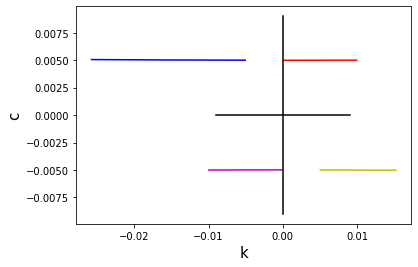

In [13]:
UpLfQ = [-0.005, .005]  # Value in upper left quadrant (Blue)
UpRtQ = [0.01, .005]   # Value in upper right quadrant (Red)
LwLfQ = [-0.01, -0.005] # Value in lower left quadrantn(Purple)
LwRtQ = [0.005, -0.005]  # Value in lower right quadrant (Yellow)

# Values in the Jacobian of the No Comittment Case
JentriesInf = np.array([[Jinf[0,0],Jinf[0,1]],[Jinf[1,0],Jinf[1,1]]])
JentriesInf = np.array([[Jinf[0,0],-1],[Jinf[1,0],0]])

print(JentriesInf)


tinf,vinf = rk4_solve(0,4,1e-2, UpLfQ,F,JentriesInf)
tinf2,vinf2 = rk4_solve(0,2,1e-2, UpRtQ,F,JentriesInf)
tinf3,vinf3 = rk4_solve(0,2,1e-2, LwLfQ,F,JentriesInf)
tinf4,vinf4 = rk4_solve(0,2,1e-2, LwRtQ,F,JentriesInf)

#np.shape(v)
plt.plot(vinf[:,0],vinf[:,1], 'b',vinf2[:,0], vinf2[:,1],'r',vinf3[:,0], vinf3[:,1],'m',vinf4[:,0], vinf4[:,1],'y',
         [-.009,.009],[0,0],'k',[0,0],[-.009, .009],'k');

plt.xlabel('k',size=15)
plt.ylabel('c',size=15);

###### The paths around the stable point, displaying the saddle paths for above the stable point.

The green circle is the starting point, and the direction the line goes shows the character of how that point reacts around the steady state.

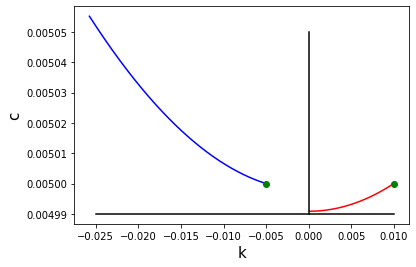

In [14]:
plt.plot(vinf[:,0],vinf[:,1], 'b', vinf2[:,0],vinf2[:,1], 'r',
         [0,0],[0.00499,.00505], 'black', [-.025, .010], [.00499,.00499], 'black',UpRtQ[0],UpRtQ[1],'go',UpLfQ[0],UpLfQ[1],'go');
plt.xlabel('k',size=15)
plt.ylabel('c',size=15);

###### The paths around the stable point, displaying the saddle paths for below the stable point.

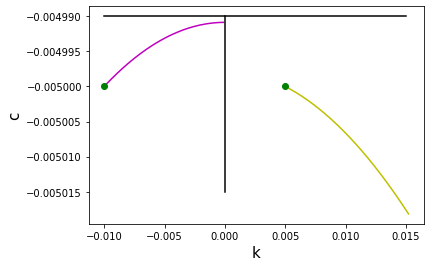

In [15]:
plt.plot(vinf3[:,0],vinf3[:,1], 'm', vinf4[:,0],vinf4[:,1], 'y',
         [0,0],[-0.00499,-0.005015], 'black', [-.010, .015], [-0.00499,-.00499], 'black', LwRtQ[0],LwRtQ[1],'go',LwLfQ[0],LwLfQ[1],'go');
plt.xlabel('k',size=15)
plt.ylabel('c',size=15);